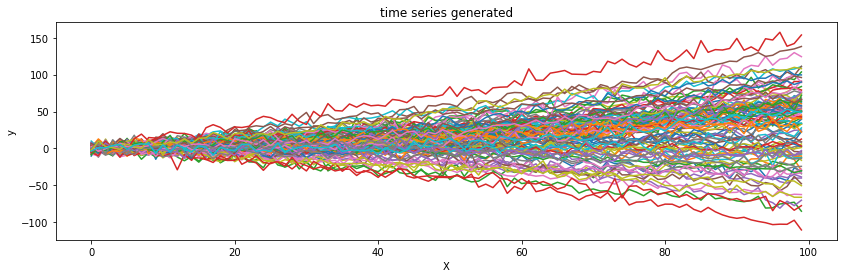

In [9]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt

class OutPiecewiseLinearChangepoints():
    def __init__(self, 
                 k, 
                 m,
                 b,
                 changepoints,
                 n_series):
        self.k = k
        self.m = m
        self.b = b
        self.changepoints = changepoints
        self.n_series = n_series

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):

        X = theano.shared(X)

        A = self.create_changepoints(X, self.changepoints)
        
        growth = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*tt.tile(X, (1, self.n_series))
        offset = (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        piecewise = growth + offset

        return piecewise
    
    def __call__(self, X):

        X = theano.shared(X)

        A = self.create_changepoints(X, self.changepoints)
        
        growth = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*tt.tile(X, (1, self.n_series))
        offset = (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        piecewise = growth + offset
        
        return piecewise.T


s = 100
n = 100
X = np.arange(n)[:, None]
piece = OutPiecewiseLinearChangepoints(k=np.array([0.1]), 
                               m=np.array([0.1]), 
                               b=np.random.normal(0.1, 0.4, size=(4,s)), 
                               changepoints = np.linspace(0, n, 4),
                               n_series = s
                               ).build(X).eval()


n_gps = 10
params_gps = {}
gps = {}
groups = {}

# GPs
for i in range(n_gps):
    groups[f'g{i}'] = np.random.choice([0,1],s).reshape(1, -1)
    params_gps[f'lengthscale{i}'] = 0.2
    params_gps[f'eta{i}'] = 2.0
    params_gps[f'cov{i}'] = params_gps[f'eta{i}'] ** 2 * pm.gp.cov.ExpQuad(1, params_gps[f'lengthscale{i}'])
    params_gps[f'K{i}'] = params_gps[f'cov{i}'](X).eval()

    params_gps[f'gp{i}'] = pm.MvNormal.dist(mu=np.zeros(params_gps[f'K{i}'].shape[0]), cov=params_gps[f'K{i}']).random(size=s).T
    gps[f'gp{i}'] = params_gps[f'gp{i}'] * groups[f'g{i}']
    
gp = sum(gps.values())

x_train = np.random.normal(gp + piece, 0.1)
plt.figure(figsize=(14, 4))
for i in range(s):
    plt.plot(X, x_train[:,i], label=f'ts_{i}')
plt.title("time series generated")
plt.ylabel("y")
plt.xlabel("X");

In [6]:
priors_gps = {}
marginal_lk_gps = {}
with pm.Model() as model:

    k = pm.Normal("k", mu=0, sigma=0.01, shape = s)
    m = pm.Normal("m", mu=0, sigma=0.01, shape = s)
    delta = pm.Normal("delta", mu=0, sigma=0.01, shape=(4,s))
    noise = pm.HalfNormal('noise',0.1)
    
    piece = OutPiecewiseLinearChangepoints(k = k,
                                          m = m,
                                          b = delta,
                                          changepoints = np.linspace(0, n, 4),
                                          n_series =s)#.build(X)
    for i in range(n_gps): 
        priors_gps[f'period{i}'] = pm.Gamma(f'period{i}', 40, 10)

        priors_gps[f'l_t{i}'] = pm.InverseGamma(f'l_t{i}', 4, 40)
        priors_gps[f'l_p{i}'] = pm.HalfNormal(f'l_p{i}', 0.5)
        priors_gps[f'η_trend{i}'] = pm.HalfNormal(f'η_trend{i}', 1)
        priors_gps[f'cov{i}'] = (priors_gps[f'η_trend{i}']**2 
                                 * pm.gp.cov.ExpQuad(input_dim=1, ls=priors_gps[f'l_t{i}']))
        priors_gps[f'gp{i}'] = pm.gp.Marginal(piece, priors_gps[f'cov{i}'])
        marginal_lk_gps[f'f{i}'] = priors_gps[f'gp{i}'].marginal_likelihood(f'f{i}', X, x_train.T * groups[f'g{i}'].T, noise)

    # Fitting using ADVI
    trace_vi = pm.fit(10000,
                       method='advi',
                       obj_n_mc=1,
                       obj_optimizer=pm.adamax(),
                       callbacks=[pm.callbacks.CheckParametersConvergence(every=50, diff='absolute',tolerance=1e-3)],
                       progressbar = True)

Finished [100%]: Average Loss = 9.7051e+06


In [7]:
priors_gps = {}
gps = {}
with pm.Model() as model:

    k = pm.Normal("k", mu=0, sigma=0.01, shape = s)
    m = pm.Normal("m", mu=0, sigma=0.01, shape = s)
    delta = pm.Normal("delta", mu=0, sigma=0.01, shape=(4,s))
    noise = pm.HalfNormal('noise',0.1)
    
    mu_func = pm.gp.mean.Zero()
    
    piece = OutPiecewiseLinearChangepoints(k = k,
                                          m = m,
                                          b = delta,
                                          changepoints = np.linspace(0, n, 4),
                                          n_series =s).build(X)
    for i in range(n_gps): 
        priors_gps[f'period{i}'] = pm.Gamma(f'period{i}', 40, 10)

        priors_gps[f'l_t{i}'] = pm.InverseGamma(f'l_t{i}', 4, 40)
        priors_gps[f'l_p{i}'] = pm.HalfNormal(f'l_p{i}', 0.5)
        priors_gps[f'η_trend{i}'] = pm.HalfNormal(f'η_trend{i}', 1)
        priors_gps[f'cov{i}'] = (priors_gps[f'η_trend{i}']**2 
                                 * pm.gp.cov.ExpQuad(input_dim=1, ls=priors_gps[f'l_t{i}']))
        
        priors_gps[f'gp{i}'] = pm.gp.Latent(mean_func=mu_func, cov_func=priors_gps[f'cov{i}'])
        priors_gps[f'f_{i}'] = priors_gps[f'gp{i}'].prior(f'f{i}', X=X, reparameterize=True)
        
        gps[f'f{i}'] = priors_gps[f'f_{i}'].reshape((-1,1))*groups[f'g{i}']
        
    
    y_pred = pm.Normal('y_pred', mu=sum(gps.values())+piece, sigma = 0.1,observed=x_train)


    # Fitting using ADVI
    trace_vi = pm.fit(10000,
                       method='advi',
                       obj_n_mc=1,
                       obj_optimizer=pm.adamax(),
                       callbacks=[pm.callbacks.CheckParametersConvergence(every=50, diff='absolute',tolerance=1e-3)],
                       progressbar = True)

Finished [100%]: Average Loss = 1.3853e+08


In [8]:
priors_gps = {}
marginal_lk_gps = {}
with pm.Model() as model:

    k = pm.Normal("k", mu=0, sigma=0.01, shape = s)
    m = pm.Normal("m", mu=0, sigma=0.01, shape = s)
    delta = pm.Normal("delta", mu=0, sigma=0.01, shape=(4,s))
    noise = pm.HalfNormal('noise',0.1)
    
    piece = OutPiecewiseLinearChangepoints(k = k,
                                          m = m,
                                          b = delta,
                                          changepoints = np.linspace(0, n, 4),
                                          n_series =s)#.build(X)
    for i in range(n_gps): 
        priors_gps[f'period{i}'] = pm.Gamma(f'period{i}', 40, 10)

        priors_gps[f'l_t{i}'] = pm.InverseGamma(f'l_t{i}', 4, 40)
        priors_gps[f'l_p{i}'] = pm.HalfNormal(f'l_p{i}', 0.5)
        priors_gps[f'η_trend{i}'] = pm.HalfNormal(f'η_trend{i}', 1)
        priors_gps[f'cov{i}'] = (priors_gps[f'η_trend{i}']**2 
                                 * pm.gp.cov.ExpQuad(input_dim=1, ls=priors_gps[f'l_t{i}']))
        priors_gps[f'gp{i}'] = pm.gp.Marginal(piece, priors_gps[f'cov{i}'])
        marginal_lk_gps[f'f{i}'] = priors_gps[f'gp{i}'].marginal_likelihood(f'f{i}', X, x_train.T * groups[f'g{i}'].T, noise)

    # Fitting using ADVI
    mp = pm.find_MAP()

In [ ]:
# Sampling
    trace_vi_samples = trace_vi.sample()
    pred_samples_fit = pm.sample_posterior_predictive(trace_vi_samples,
                                                           vars=[y_pred],
                                                           samples=n_samples,
                                                      progressbar = True)
    
    # Conditional of the GP on new points
    f_n = gp.conditional('f_n', Xnew=X_new)

    piece = OutPiecewiseLinearChangepoints(k = k,
                                          m = m,
                                          b = delta,
                                          changepoints = changepoints_t).build(X_new)

    
    y_pred_new = pm.Normal("y_pred_new", 
                            mu=f_n.reshape((-1,1)) + piece, 
                            shape=(X_new.shape[0], s))
    
    # Sampling of predictions
    pred_samples_predict = pm.sample_posterior_predictive(trace_vi_samples, 
                                              vars=[y_pred_new], 
                                              samples=n_samples,
                                              progressbar = True)